In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "../input/dateexpiration/data"

BATCH_SIZE = 64
IMG_SIZE = (160, 160)

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    subset="training",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.3,
)

Found 360000 files belonging to 3600 classes.
Using 252000 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    subset="validation",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.3,
)

Found 360000 files belonging to 3600 classes.
Using 108000 files for validation.


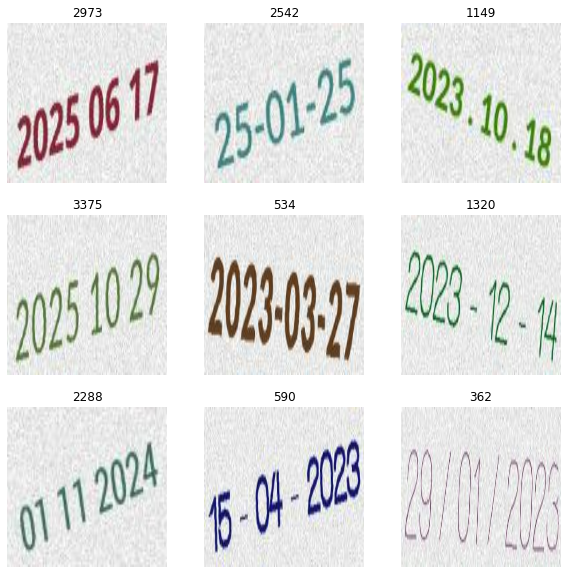

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 1351
Number of test batches: 337


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

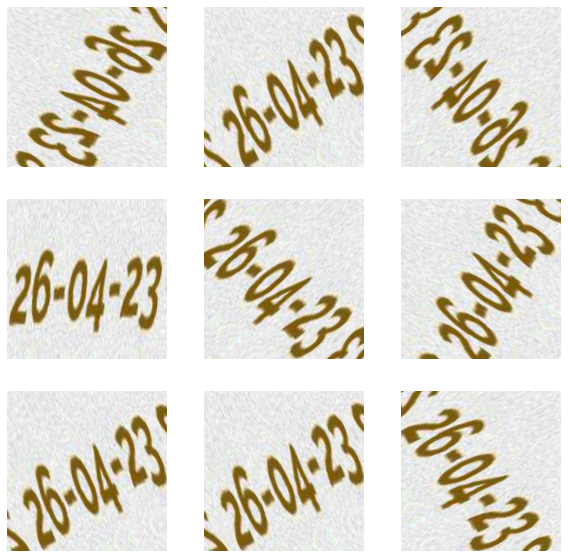

In [10]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [11]:
preprocessing_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Base Model

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

219070464/219055592 [==============================] - 1s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1536)


In [15]:
base_model.trainable = False

### add classification head

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1536)


In [17]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 3600)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocessing_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

1351/1351 [==============================] - 533s 239ms/step - loss: 8.3967 - accuracy: 3.3552e-04


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.40
initial accuracy: 0.00


In [24]:
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    batch_size=BATCH_SIZE
)

Epoch 1/10
3938/3938 [==============================] - 1128s 284ms/step - loss: 8.5352 - accuracy: 6.5873e-04 - val_loss: 8.1182 - val_accuracy: 0.0014
Epoch 2/10
3938/3938 [==============================] - 972s 247ms/step - loss: 8.2611 - accuracy: 0.0014 - val_loss: 8.0143 - val_accuracy: 0.0016
Epoch 3/10
3938/3938 [==============================] - 965s 245ms/step - loss: 8.1379 - accuracy: 0.0022 - val_loss: 7.9399 - val_accuracy: 0.0025
Epoch 4/10
3938/3938 [==============================] - 961s 244ms/step - loss: 8.0406 - accuracy: 0.0026 - val_loss: 7.8804 - val_accuracy: 0.0032
Epoch 5/10
3938/3938 [==============================] - 967s 245ms/step - loss: 7.9646 - accuracy: 0.0031 - val_loss: 7.8306 - val_accuracy: 0.0034
Epoch 6/10
3938/3938 [==============================] - 967s 245ms/step - loss: 7.9012 - accuracy: 0.0034 - val_loss: 7.7931 - val_accuracy: 0.0038
Epoch 7/10
3938/3938 [==============================] - 973s 247ms/step - loss: 7.8472 - accuracy: 0.0041 -

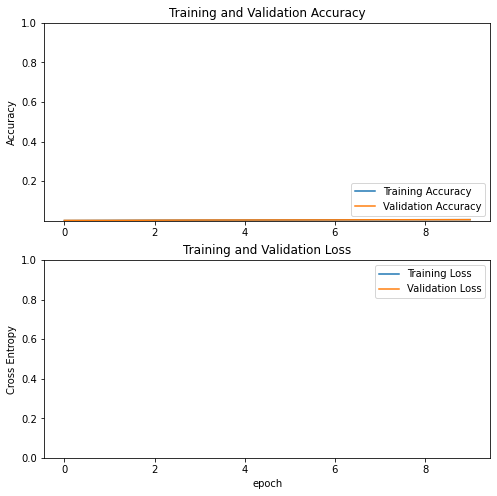

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  780


In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         batch_size=BATCH_SIZE)

Epoch 10/20
3938/3938 [==============================] - 2363s 593ms/step - loss: 4.5539 - accuracy: 0.1120 - val_loss: 2.5009 - val_accuracy: 0.3377
Epoch 11/20
3938/3938 [==============================] - 2334s 592ms/step - loss: 2.1781 - accuracy: 0.4057 - val_loss: 0.8499 - val_accuracy: 0.7697
Epoch 12/20
3938/3938 [==============================] - 2335s 593ms/step - loss: 1.0988 - accuracy: 0.6745 - val_loss: 0.3759 - val_accuracy: 0.9011
Epoch 13/20
3938/3938 [==============================] - 2333s 592ms/step - loss: 0.6073 - accuracy: 0.8194 - val_loss: 0.1880 - val_accuracy: 0.9488
Epoch 14/20
3938/3938 [==============================] - 2331s 592ms/step - loss: 0.3933 - accuracy: 0.8849 - val_loss: 0.1341 - val_accuracy: 0.9632
Epoch 15/20
3938/3938 [==============================] - 2329s 591ms/step - loss: 0.2909 - accuracy: 0.9162 - val_loss: 0.1100 - val_accuracy: 0.9700
Epoch 16/20
3938/3938 [==============================] - 2327s 591ms/step - loss: 0.2369 - accuracy:

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

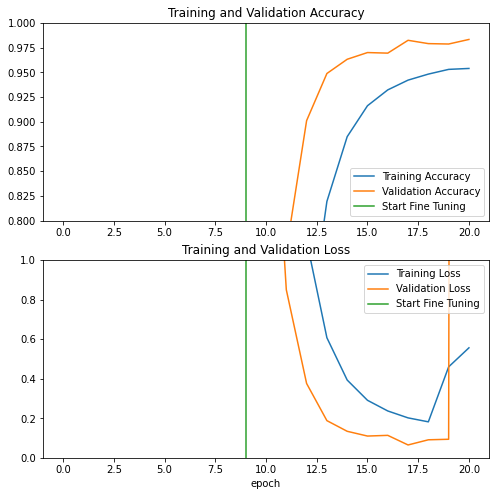

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

337/337 [==============================] - 60s 177ms/step - loss: 8.6204 - accuracy: 0.9825
Test accuracy : 0.9824740290641785


In [36]:
model.save("models/inception_resnetv2_98.h5")

In [ ]:
./